In [114]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler

)
from sklearn.impute import SimpleImputer
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss, auc
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [115]:
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"]
df = pd.read_csv('data/heart+disease/processed.cleveland.data', header=None, names=cols)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [116]:
# Đổi '?' -> NaN và ép kiểu số
df = df.replace("?", np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")
# nhị phân hóa nhãn: 0 = không bệnh, 1–4 = có bệnh
df["target"] = (df["target"] > 0).astype(int)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [117]:
print("Thiếu dữ liệu mỗi cột:\n", df.isna().sum())
display(df.head())

Thiếu dữ liệu mỗi cột:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [118]:
# Kiểm tra dữ liệu thiếu
missing = df.isna().sum().sort_values(ascending=False)
print(missing)

ca          4
thal        2
cp          0
trestbps    0
age         0
sex         0
fbs         0
chol        0
restecg     0
thalach     0
oldpeak     0
exang       0
slope       0
target      0
dtype: int64


## Kiểm tra phân phối nhãn (có lệch lớp không?)


Phân phối nhãn (số lượng):
 target
0    164
1    139
Name: count, dtype: int64

Tỉ lệ nhãn:
 target
0    0.541
1    0.459
Name: count, dtype: float64


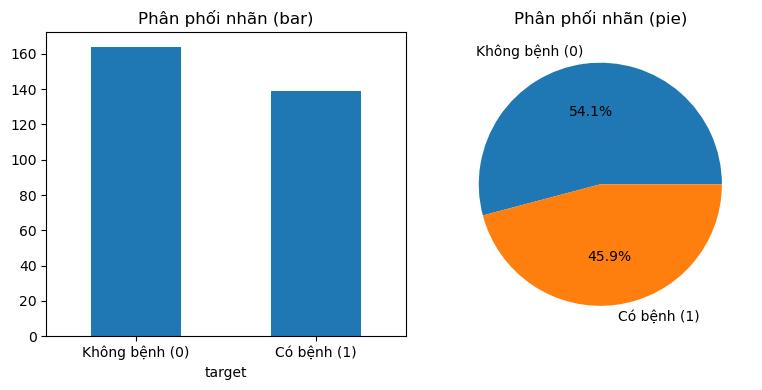

In [119]:
y_counts = df["target"].value_counts().sort_index()
print("\nPhân phối nhãn (số lượng):\n", y_counts)
print("\nTỉ lệ nhãn:\n", (y_counts / len(df)).round(3))

fig, axes = plt.subplots(1, 2, figsize=(8,4))
y_counts.plot(kind="bar", ax=axes[0])
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(["Không bệnh (0)", "Có bệnh (1)"], rotation=0)
axes[0].set_title("Phân phối nhãn (bar)")

y_counts.plot(kind="pie", autopct="%.1f%%",
              labels=["Không bệnh (0)", "Có bệnh (1)"],
              ylabel="", ax=axes[1])
axes[1].set_title("Phân phối nhãn (pie)")
plt.tight_layout(); plt.show()

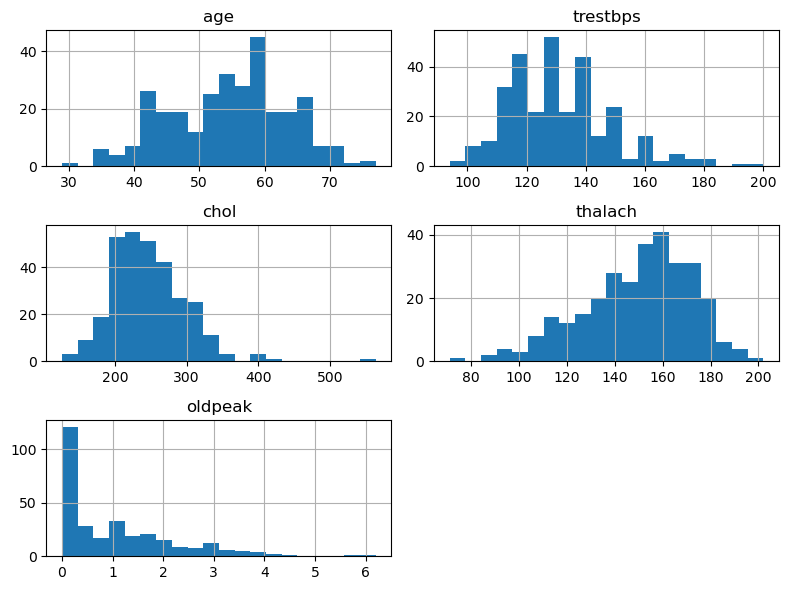

In [120]:
# Phân phối một vài biến số
num_cols_quick = ["age","trestbps","chol","thalach","oldpeak"]
df[num_cols_quick].hist(bins=20, figsize=(8,6))
plt.tight_layout(); plt.show()


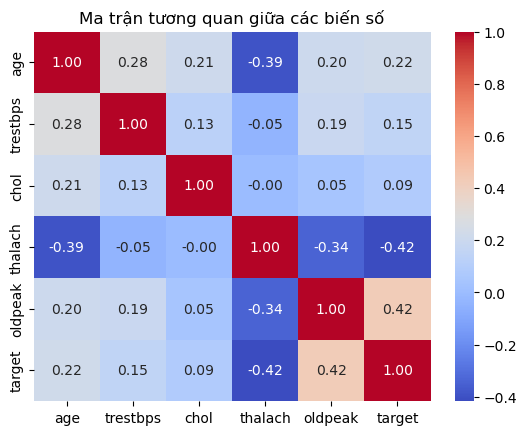

In [121]:
numeric_cols = ["age","trestbps","chol","thalach","oldpeak"]
corr = df[numeric_cols + ["target"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các biến số")
plt.show(); plt.close()

Tổng quan dữ liệu:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


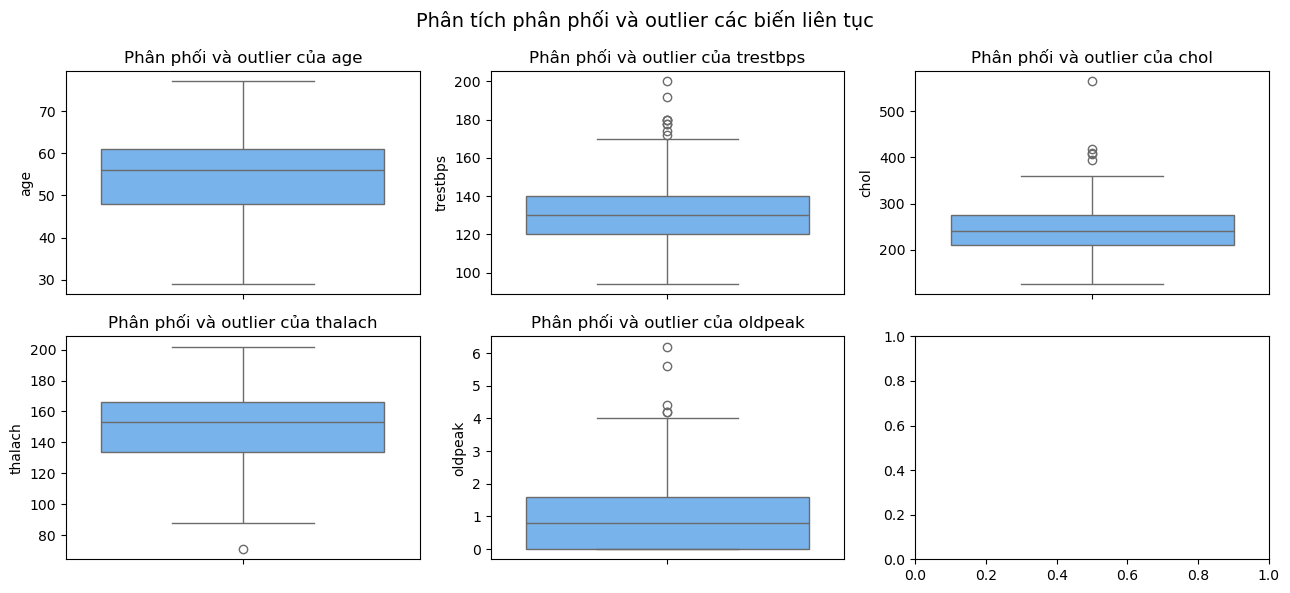

In [122]:
print("Tổng quan dữ liệu:")
display(df.describe())

# Kiểm tra outlier bằng boxplot
num_cols_plot = ["age","trestbps","chol","thalach","oldpeak"]
fig, axes = plt.subplots(2, 3, figsize=(13,6))
axes = axes.ravel()
for i, col in enumerate(num_cols_plot):
    sns.boxplot(y=df[col], ax=axes[i], color="#66b3ff")
    axes[i].set_title(f"Phân phối và outlier của {col}")
plt.suptitle("Phân tích phân phối và outlier các biến liên tục", fontsize=14)
plt.tight_layout(); plt.show(); plt.close()


## Chia dữ liệu: train / test 80/20

In [123]:
# Chia dữ liệu: trainval / test (80 / 20)
X = df.drop(columns=["target"])
y = df["target"]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("Kích thước tập:",
      "trainval =", len(X_trainval),
      "test =", len(X_test))



Kích thước tập: trainval = 242 test = 61


## Tiền xử lý (impute + scale + one-hot)

In [124]:
## Tiền xử lý (impute + scale + one-hot)
# num_cols = ["age","trestbps","chol","thalach","oldpeak"]
# cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal","ca"]

num_cols = ["age","trestbps","chol","thalach","oldpeak"]
binary_cols = ["sex", "fbs", "exang"]
multi_cat_cols = ["cp", "restecg", "slope", "thal", "ca"]

def make_preprocess():
    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

    binary_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
        # KHÔNG one-hot, để nguyên 0/1
    ])

    multi_cat_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(transformers=[
        ("num", numeric_tf, num_cols),
        ("bin", binary_tf, binary_cols),
        ("cat", multi_cat_tf, multi_cat_cols),
    ])
    return pre
preprocess = make_preprocess()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# preprocess = make_preprocess()
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hàm huấn luyện & đánh giá chung cho mọi mô hình

In [125]:
def fit_eval(model, name, preprocess,
             X_trainval, y_trainval, X_test, y_test, cv):
    """
    - Val AUC: AUC out-of-fold (5-fold CV) trên tập trainval (80%)
    - Test AUC, Accuracy, Precision, Recall, F1: tính trên tập test (20%)
    """
    pipe = Pipeline(steps=[("pre", preprocess), ("clf", model)])

    # Out-of-fold prob trên trainval
    oof_proba = cross_val_predict(
        pipe,
        X_trainval, y_trainval,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]
    val_auc = roc_auc_score(y_trainval, oof_proba)

    # Fit lại trên toàn bộ trainval
    pipe.fit(X_trainval, y_trainval)

    # Đánh giá trên TEST
    test_proba = pipe.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= 0.5).astype(int)

    metrics = {
        "Model": name,
        "Val AUC": val_auc,
        "Test AUC": roc_auc_score(y_test, test_proba),
        "Accuracy": accuracy_score(y_test, test_pred),
        "Precision": precision_score(y_test, test_pred, zero_division=0),
        "Recall": recall_score(y_test, test_pred, zero_division=0),
        "F1": f1_score(y_test, test_pred, zero_division=0),
        "pipe": pipe,
        "test_proba": test_proba,
        "test_pred": test_pred,
    }
    return metrics

## Định nghĩa & train 6 mô hình (baseline so sánh)

In [126]:
results = []

In [127]:
# 1) Logistic Regression
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    C=1.0,
    solver="lbfgs"
)
res_lr = fit_eval(lr, "Logistic Regression", preprocess,
                  X_trainval, y_trainval, X_test, y_test, skf)
results.append(res_lr)


In [128]:
# 2) Decision Tree
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    min_samples_split=10,
    random_state=42
)
res_dt = fit_eval(dt, "Decision Tree", preprocess,
                  X_trainval, y_trainval, X_test, y_test, skf)
results.append(res_dt)

In [129]:
# 3) Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced"
)
res_rf = fit_eval(rf, "Random Forest", preprocess,
                  X_trainval, y_trainval, X_test, y_test, skf)
results.append(res_rf)


In [130]:
# 4) SVM (RBF)
svc = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)
res_svc = fit_eval(svc, "SVM (RBF)", preprocess,
                   X_trainval, y_trainval, X_test, y_test, skf)
results.append(res_svc)


In [131]:

# 5) XGBoost 
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42
    )
    res_xgb = fit_eval(xgb, "XGBoost", preprocess,
                       X_trainval, y_trainval, X_test, y_test, skf)
    results.append(res_xgb)
else:
    res_xgb = None

In [132]:
from sklearn.ensemble import VotingClassifier

# 6) Voting Ensemble (kết hợp 4–5 mô hình trên)
estimators = [
    ("lr", lr),
    ("dt", dt),
    ("rf", rf),
    ("svc", svc),
]

# nếu có XGBoost thì thêm luôn vào ensemble
if HAS_XGB:
    estimators.append(("xgb", xgb))

voting = VotingClassifier(
    estimators=estimators,
    voting="soft"  # dùng xác suất trung bình
    # có thể thêm n_jobs=-1 nếu sklearn version hỗ trợ
)

res_vote = fit_eval(
    voting,
    "Voting Ensemble",
    preprocess,
    X_trainval, y_trainval,
    X_test, y_test,
    skf
)
results.append(res_vote)


## Bảng tổng hợp kết quả (baseline)

In [133]:
## Bảng tổng hợp kết quả (baseline )
summary = pd.DataFrame([{
    "Model": r["Model"],
    "Val AUC": round(r["Val AUC"], 3),
    "Test AUC": round(r["Test AUC"], 3),
    "Accuracy": round(r["Accuracy"], 3),
    "Precision": round(r["Precision"], 3),
    "Recall": round(r["Recall"], 3),
    "F1": round(r["F1"], 3),
} for r in results]).sort_values("Val AUC", ascending=False).reset_index(drop=True)

print("Kết quả so sánh mô hình (baseline )")
display(summary)

best_baseline = max(results, key=lambda r: r["Val AUC"])
best_name = best_baseline["Model"]
best_pipe = best_baseline["pipe"]
print("Mô hình tốt nhất (baseline, theo CV AUC):", best_name)

## Baseline của bài báo UCI (không feature selection)
paper_baseline = pd.DataFrame({
    "Model": ["Random Forest", "SVM (RBF)", "Logistic Regression"],
    "Paper Accuracy":  [0.897, 0.870, 0.842],
    "Paper Precision": [0.86,  0.84,  0.77 ],
    "Paper Recall":    [0.90,  0.84,  0.88 ],
    "Paper F1":        [0.88,  0.84,  0.82 ],
})

summary_compare = summary.merge(paper_baseline, on="Model", how="left")
print(" So sánh với baseline từ bài báo UCI")
display(summary_compare)


Kết quả so sánh mô hình (baseline )


,Model,Val AUC,Test AUC,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.906,0.956,0.885,0.839,0.929,0.881
1,SVM (RBF),0.904,0.939,0.852,0.806,0.893,0.847
2,Random Forest,0.888,0.939,0.902,0.844,0.964,0.900
3,Voting Ensemble,0.884,0.940,0.902,0.867,0.929,0.897
4,XGBoost,0.865,0.943,0.869,0.812,0.929,0.867
5,Decision Tree,0.780,0.864,0.770,0.719,0.821,0.767


Mô hình tốt nhất (baseline, theo CV AUC): Logistic Regression
 So sánh với baseline từ bài báo UCI


,Model,Val AUC,Test AUC,Accuracy,Precision,Recall,F1,Paper Accuracy,Paper Precision,Paper Recall,Paper F1
0,Logistic Regression,0.906,0.956,0.885,0.839,0.929,0.881,0.842,0.77,0.88,0.82
1,SVM (RBF),0.904,0.939,0.852,0.806,0.893,0.847,0.870,0.84,0.84,0.84
2,Random Forest,0.888,0.939,0.902,0.844,0.964,0.900,0.897,0.86,0.90,0.88
3,Voting Ensemble,0.884,0.940,0.902,0.867,0.929,0.897,NaN,NaN,NaN,NaN
4,XGBoost,0.865,0.943,0.869,0.812,0.929,0.867,NaN,NaN,NaN,NaN
5,Decision Tree,0.780,0.864,0.770,0.719,0.821,0.767,NaN,NaN,NaN,NaN


In [134]:
summary_compare = summary.merge(paper_baseline, on="Model", how="left")
print(" UCI")
display(summary_compare)


 UCI


,Model,Val AUC,Test AUC,Accuracy,Precision,Recall,F1,Paper Accuracy,Paper Precision,Paper Recall,Paper F1
0,Logistic Regression,0.906,0.956,0.885,0.839,0.929,0.881,0.842,0.77,0.88,0.82
1,SVM (RBF),0.904,0.939,0.852,0.806,0.893,0.847,0.870,0.84,0.84,0.84
2,Random Forest,0.888,0.939,0.902,0.844,0.964,0.900,0.897,0.86,0.90,0.88
3,Voting Ensemble,0.884,0.940,0.902,0.867,0.929,0.897,NaN,NaN,NaN,NaN
4,XGBoost,0.865,0.943,0.869,0.812,0.929,0.867,NaN,NaN,NaN,NaN
5,Decision Tree,0.780,0.864,0.770,0.719,0.821,0.767,NaN,NaN,NaN,NaN


In [135]:

plot_df = summary_compare.copy()

# Nhân 100 để ra %
for col in ["Accuracy", "Precision", "Paper Accuracy", "Paper Precision"]:
    plot_df[col] = plot_df[col] * 100

# Sắp xếp thứ tự model cho đẹp (nếu thiếu model nào thì nó tự bỏ qua)
order = ["XGBoost", "SVM (RBF)", "Random Forest", "Neural Network", "Logistic Regression"]
plot_df = plot_df.set_index("Model").loc[[m for m in order if m in plot_df["Model"].values]].reset_index()


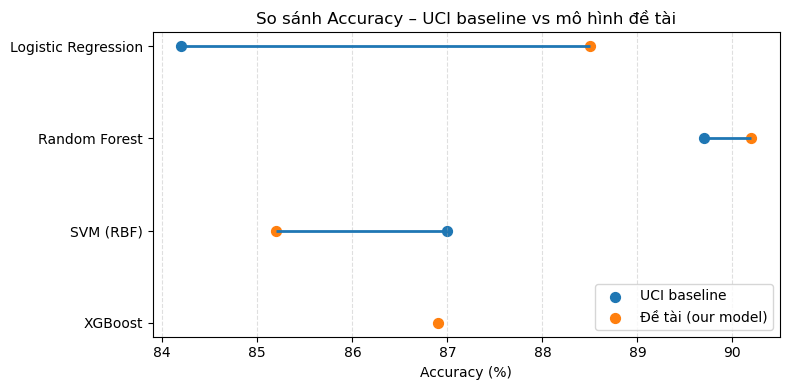

In [136]:
# ----- Accuracy -----
fig, ax = plt.subplots(figsize=(8, 4))

y_pos = np.arange(len(plot_df))

# vẽ đoạn thẳng nối từ UCI -> kết quả của mình
ax.hlines(
    y=y_pos,
    xmin=plot_df["Paper Accuracy"],
    xmax=plot_df["Accuracy"],
    linewidth=2
)

# chấm tròn UCI baseline
ax.scatter(plot_df["Paper Accuracy"], y_pos, s=50, label="UCI baseline")

# chấm tròn kết quả của đề tài
ax.scatter(plot_df["Accuracy"], y_pos, s=50, label="Đề tài (our model)")

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df["Model"])
ax.set_xlabel("Accuracy (%)")
ax.set_title("So sánh Accuracy – UCI baseline vs mô hình đề tài")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


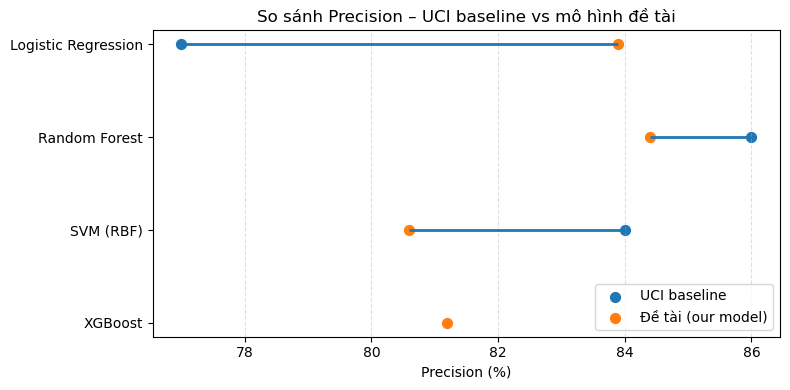

In [137]:
# ----- Precision -----
fig, ax = plt.subplots(figsize=(8, 4))

y_pos = np.arange(len(plot_df))

ax.hlines(
    y=y_pos,
    xmin=plot_df["Paper Precision"],
    xmax=plot_df["Precision"],
    linewidth=2
)

ax.scatter(plot_df["Paper Precision"], y_pos, s=50, label="UCI baseline")
ax.scatter(plot_df["Precision"], y_pos, s=50, label="Đề tài (our model)")

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df["Model"])
ax.set_xlabel("Precision (%)")
ax.set_title("So sánh Precision – UCI baseline vs mô hình đề tài")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


## ROC Curve gộp để so sánh các mô hình

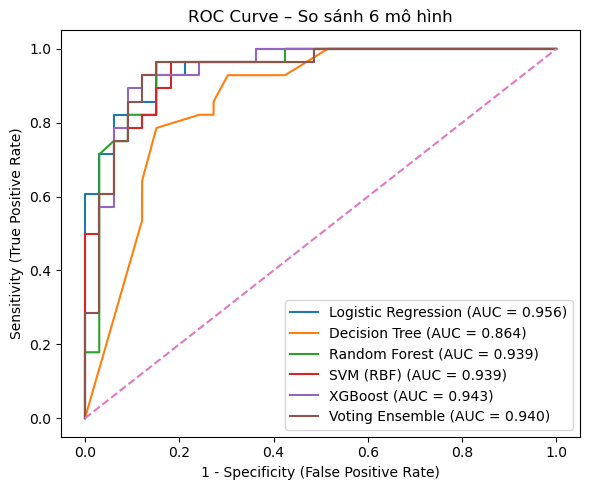

In [161]:
plt.figure(figsize=(6,5))
for r in results:
    y_score = r["test_proba"]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{r['Model']} (AUC = {auc_val:.3f})")

plt.plot([0,1],[0,1],"--")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.title("ROC Curve – So sánh 6 mô hình")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Confusion Matrix grid

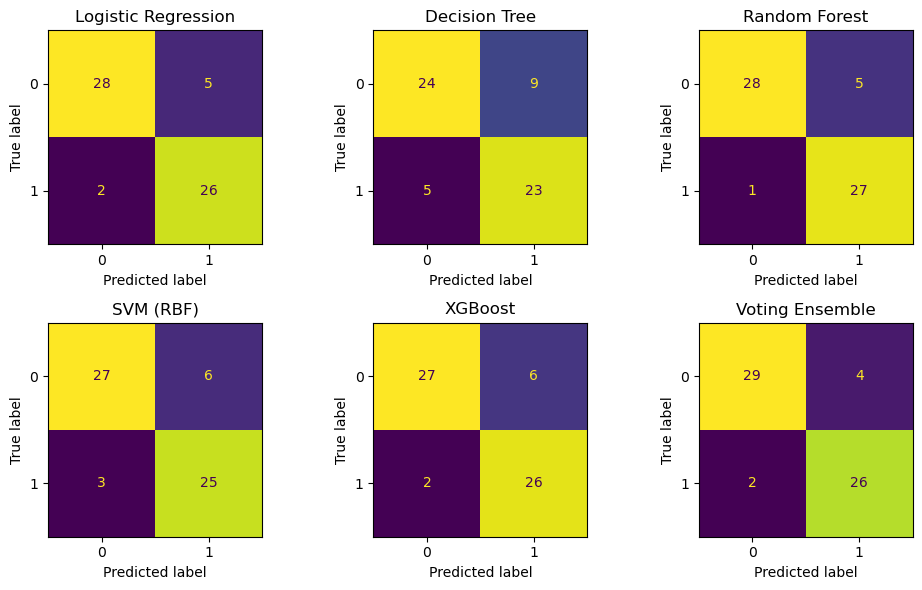

In [139]:
n_models = len(results)
n_rows, n_cols = 2, 3  # đủ cho 5 model
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.ravel()

for i, r in enumerate(results):
    cm = confusion_matrix(y_test, r["test_pred"])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(r["Model"])

for j in range(n_models, n_rows * n_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Ảnh hưởng của biến so với đầu ra (boxplot theo target)

/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_23968/877473278.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["0: không bệnh", "1: có bệnh"], rotation=30)
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_23968/877473278.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["0: không bệnh", "1: có bệnh"], rotation=30)
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_23968/877473278.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["0: không bệnh", "1: có bệnh"], rotation=30)
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_23968/877473278.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of tic

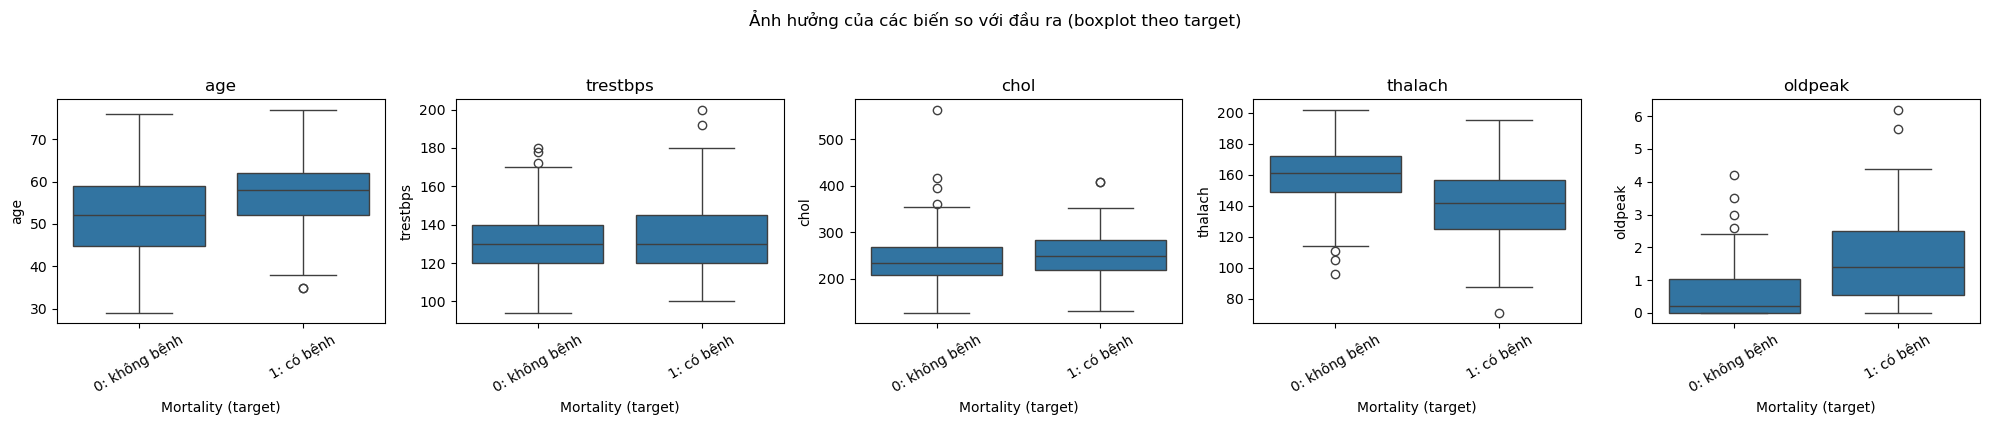

In [140]:

selected_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, axes = plt.subplots(1, len(selected_cols),
                         figsize=(4 * len(selected_cols), 4),
                         sharex=False, sharey=False)

for i, col in enumerate(selected_cols):
    sns.boxplot(x="target", y=col, data=df, ax=axes[i])
    axes[i].set_xlabel("Mortality (target)")
    axes[i].set_xticklabels(["0: không bệnh", "1: có bệnh"], rotation=30)
    axes[i].set_title(col)

fig.suptitle("Ảnh hưởng của các biến so với đầu ra (boxplot theo target)", y=1.05)
plt.tight_layout()
plt.show()


## Thử nghiệm xử lý dữ liệu thiếu:
#     1) Drop toàn bộ dòng có NaN
#     2) Giữ lại và dùng SimpleImputer
#     (dùng RandomForest để minh hoạ)

In [141]:
def run_rf_with_missing(strategy="impute"):
    """
    strategy:
        - "impute": giữ nguyên df, dùng SimpleImputer (median/mode)
        - "drop": bỏ mọi dòng có NaN rồi train
    trả về: (y_true, y_score, y_pred, label)
    """
    if strategy == "drop":
        df_use = df.dropna().copy()
        label = "RF – Drop NaN"
    else:
        df_use = df.copy()
        label = "RF – SimpleImputer"

    X_use = df_use.drop(columns=["target"])
    y_use = df_use["target"]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_use, y_use,
        test_size=0.2,
        stratify=y_use,
        random_state=42
    )

    pre = make_preprocess()
    rf_m = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        max_features="sqrt",
        random_state=42,
        class_weight="balanced"
    )
    pipe = Pipeline([("pre", pre), ("clf", rf_m)])
    pipe.fit(X_tr, y_tr)

    y_score = pipe.predict_proba(X_te)[:, 1]
    y_pred = (y_score >= 0.5).astype(int)
    return y_te.values, y_score, y_pred, label

y_te_imp, y_sc_imp, y_pr_imp, label_imp = run_rf_with_missing("impute")
y_te_drop, y_sc_drop, y_pr_drop, label_drop = run_rf_with_missing("drop")

### # ROC so sánh 2 chiến lược xử lý thiếu

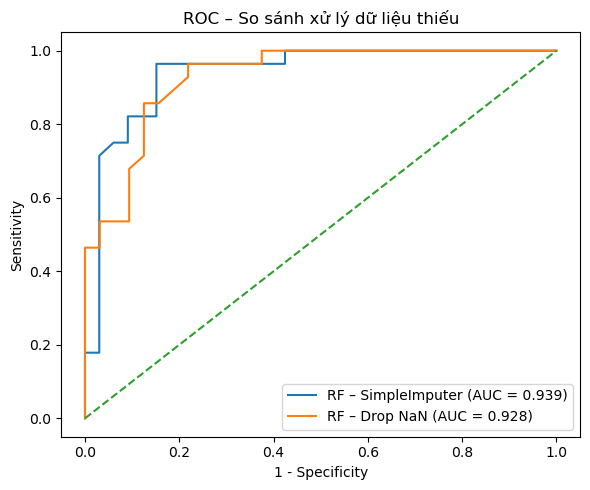

In [142]:
plt.figure(figsize=(6, 5))
for y_true, y_score, label in [
    (y_te_imp, y_sc_imp, label_imp),
    (y_te_drop, y_sc_drop, label_drop)
]:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], "--")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("ROC – So sánh xử lý dữ liệu thiếu")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### # Confusion matrix 2 chiến lược

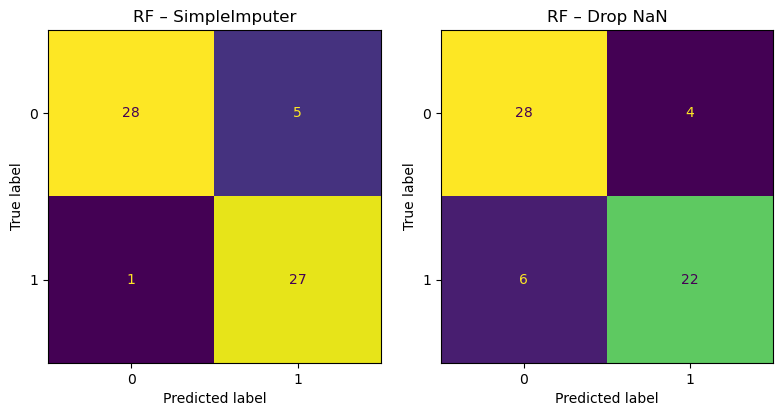

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
cm_imp = confusion_matrix(y_te_imp, y_pr_imp)
disp_imp = ConfusionMatrixDisplay(cm_imp, display_labels=[0, 1])
disp_imp.plot(ax=axes[0], colorbar=False)
axes[0].set_title(label_imp)

cm_drop = confusion_matrix(y_te_drop, y_pr_drop)
disp_drop = ConfusionMatrixDisplay(cm_drop, display_labels=[0, 1])
disp_drop.plot(ax=axes[1], colorbar=False)
axes[1].set_title(label_drop)

plt.tight_layout()
plt.show()

## Thử nghiệm dữ liệu mất cân bằng:
#     1) Không xử lý
#     2) Dùng class_weight='balanced'
#     3) Dùng SMOTE
#     (cũng dùng RandomForest để minh hoạ)

In [144]:
def run_rf_imbalance(strategy="none"):
    """
    strategy:
        - "none"   : không xử lý imbalance
        - "weight" : class_weight='balanced'
        - "smote"  : dùng SMOTE sau preprocess
    """
    X_use = X.copy()
    y_use = y.copy()

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_use, y_use,
        test_size=0.2,
        stratify=y_use,
        random_state=42
    )

    if strategy == "none":
        pre = make_preprocess()
        clf = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            max_features="sqrt",
            random_state=42,
            class_weight=None
        )
        pipe = Pipeline([("pre", pre), ("clf", clf)])
        label = "RF – Không xử lý imbalance"

    elif strategy == "weight":
        pre = make_preprocess()
        clf = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            max_features="sqrt",
            random_state=42,
            class_weight="balanced"
        )
        pipe = Pipeline([("pre", pre), ("clf", clf)])
        label = "RF – class_weight='balanced'"

    else:  # SMOTE
        pre = make_preprocess()
        clf = RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            max_features="sqrt",
            random_state=42,
            class_weight=None
        )
        pipe = ImbPipeline([
            ("pre", pre),
            ("smote", SMOTE(random_state=42)),
            ("clf", clf)
        ])
        label = "RF – SMOTE"

    pipe.fit(X_tr, y_tr)
    y_score = pipe.predict_proba(X_te)[:, 1]
    y_pred = (y_score >= 0.5).astype(int)
    return y_te.values, y_score, y_pred, label

y_te_n, y_sc_n, y_pr_n, lb_n = run_rf_imbalance("none")
y_te_w, y_sc_w, y_pr_w, lb_w = run_rf_imbalance("weight")
y_te_s, y_sc_s, y_pr_s, lb_s = run_rf_imbalance("smote")

### # ROC 3 chiến lược imbalance

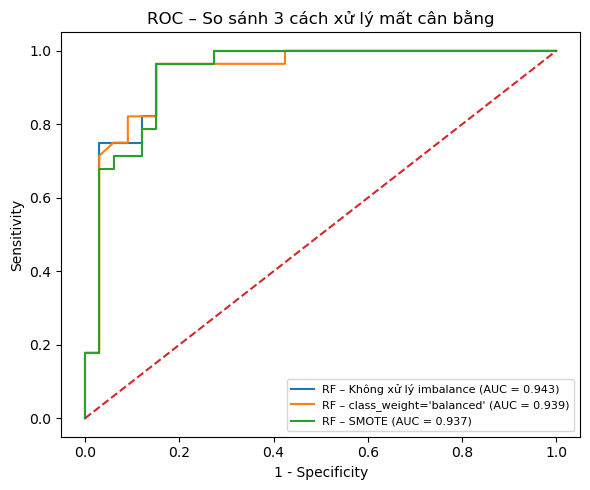

In [145]:
plt.figure(figsize=(6, 5))
for y_true, y_score, label in [
    (y_te_n, y_sc_n, lb_n),
    (y_te_w, y_sc_w, lb_w),
    (y_te_s, y_sc_s, lb_s),
]:
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], "--")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("ROC – So sánh 3 cách xử lý mất cân bằng")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

### # Confusion matrix 3 chiến lược imbalance

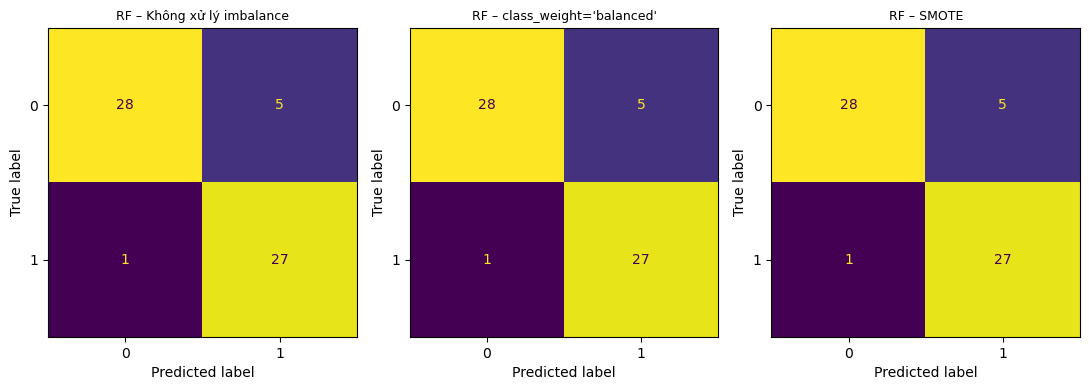

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(11, 4))
for ax, (y_true, y_pred, title) in zip(
    axes,
    [
        (y_te_n, y_pr_n, lb_n),
        (y_te_w, y_pr_w, lb_w),
        (y_te_s, y_pr_s, lb_s),
    ]
):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title, fontsize=9)

plt.tight_layout()
plt.show()

## GridSearch (LR, SVC, RF) → chọn mô hình tốt nhất theo CV AUC

In [147]:
pipe_lr = Pipeline([
    ("pre", make_preprocess()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
grid_lr = {"clf__C": [0.1, 0.5, 1.0, 3.0]}
gs_lr = GridSearchCV(pipe_lr, grid_lr, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_lr.fit(X_trainval, y_trainval)
print("[LR] best params:", gs_lr.best_params_,
      "| best cv AUC:", round(gs_lr.best_score_, 4))

pipe_svc = Pipeline([
    ("pre", make_preprocess()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])
grid_svc = {
    "clf__C": [0.5, 1.0, 3.0],
    "clf__gamma": ["scale", 0.1, 0.01]
}
gs_svc = GridSearchCV(pipe_svc, grid_svc, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_svc.fit(X_trainval, y_trainval)
print("[SVC] best params:", gs_svc.best_params_,
      "| best cv AUC:", round(gs_svc.best_score_, 4))

pipe_rf = Pipeline([
    ("pre", make_preprocess()),
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
])
grid_rf = {
    "clf__n_estimators": [300, 400],
    "clf__max_features": ["sqrt", "log2"],
    "clf__max_depth": [None, 8, 12]
}
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_rf.fit(X_trainval, y_trainval)
print("[RF] best params:", gs_rf.best_params_,
      "| best cv AUC:", round(gs_rf.best_score_, 4))

gs_candidates = [gs_lr, gs_svc, gs_rf]
gs_best = max(gs_candidates, key=lambda g: g.best_score_)

best_on_train = gs_best.best_estimator_
print("\n=== Mô hình chọn theo GridSearch cv AUC ===")
print("Tên:", type(best_on_train.named_steps["clf"]).__name__,
      "| best CV AUC:", round(gs_best.best_score_, 4),
      "| params:", gs_best.best_params_)


[LR] best params: {'clf__C': 0.1} | best cv AUC: 0.9131
[SVC] best params: {'clf__C': 0.5, 'clf__gamma': 0.01} | best cv AUC: 0.912
[RF] best params: {'clf__max_depth': 8, 'clf__max_features': 'log2', 'clf__n_estimators': 300} | best cv AUC: 0.8983

=== Mô hình chọn theo GridSearch cv AUC ===
Tên: LogisticRegression | best CV AUC: 0.9131 | params: {'clf__C': 0.1}


## Chọn ngưỡng tối ưu theo F1 trên tập VAL

In [148]:
# Out-of-fold prob từ best_on_train trên trainval
oof_best = cross_val_predict(
    best_on_train,
    X_trainval, y_trainval,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

def pick_threshold_for_best_f1(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i = np.nanargmax(f1s)
    return max(thr[i - 1], 0.0) if i > 0 and i - 1 < len(thr) else 0.5

opt_th = pick_threshold_for_best_f1(y_trainval.values, oof_best)
print("Ngưỡng tối ưu (F1) từ KFold trên trainval:", round(opt_th, 3))


Ngưỡng tối ưu (F1) từ KFold trên trainval: 0.525


## Refit model tốt nhất trên TRAIN+VAL → đánh giá trên TEST

In [149]:
final_model = clone(best_on_train)
final_model.fit(X_trainval, y_trainval)

test_proba_final = final_model.predict_proba(X_test)[:, 1]
test_pred_final = (test_proba_final >= opt_th).astype(int)

print("\n Hiệu năng FINAL MODEL (uncalibrated) trên TEST ")
print("Test AUC:", roc_auc_score(y_test, test_proba_final))
print("Accuracy:", accuracy_score(y_test, test_pred_final))
print("Precision:", precision_score(y_test, test_pred_final, zero_division=0))
print("Recall:", recall_score(y_test, test_pred_final, zero_division=0))
print("F1:", f1_score(y_test, test_pred_final, zero_division=0))



 Hiệu năng FINAL MODEL (uncalibrated) trên TEST 
Test AUC: 0.9512987012987012
Accuracy: 0.8688524590163934
Precision: 0.8571428571428571
Recall: 0.8571428571428571
F1: 0.8571428571428571


#### ROC & PR của final_model (uncalibrated)

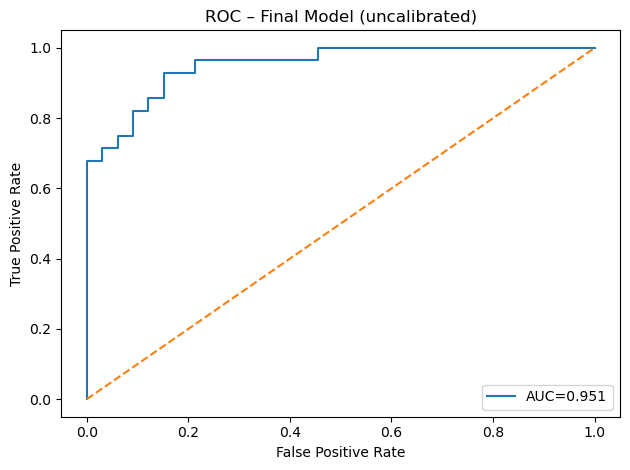

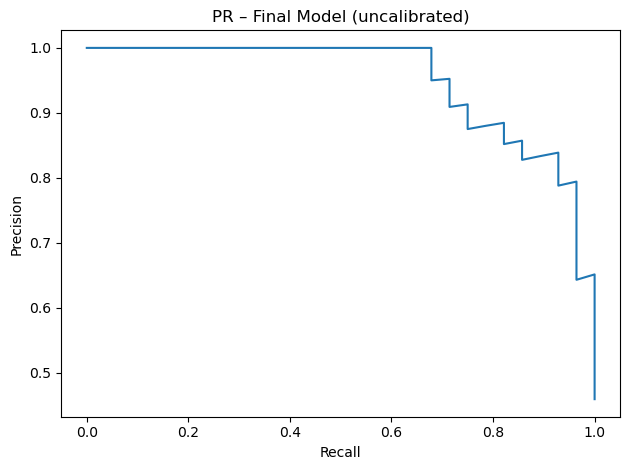

In [150]:
fpr, tpr, _ = roc_curve(y_test, test_proba_final)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, test_proba_final):.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Final Model (uncalibrated)")
plt.legend()
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, test_proba_final)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR – Final Model (uncalibrated)")
plt.tight_layout()
plt.show()

## Calibration & Brier score – trước khi hiệu chỉnh

Brier score (uncalibrated, test): 0.1052


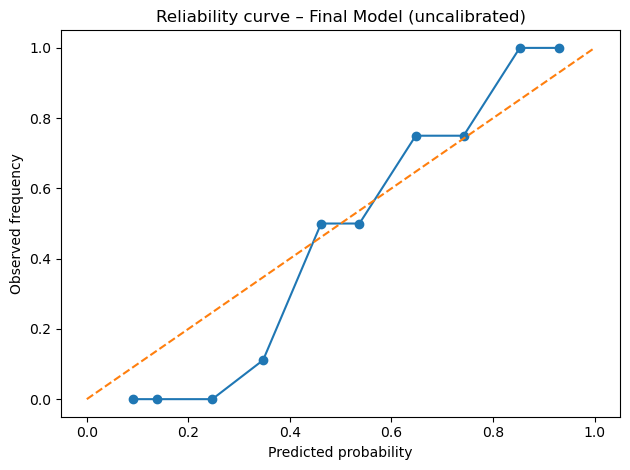

In [151]:
y_score_uncal = test_proba_final
print("Brier score (uncalibrated, test):",
      round(brier_score_loss(y_test, y_score_uncal), 4))

prob_true, prob_pred = calibration_curve(y_test, y_score_uncal, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability curve – Final Model (uncalibrated)")
plt.tight_layout()
plt.show()


## Calibration trên TRAINVAL (isotonic) cho final_model

In [152]:
pre = final_model.named_steps["pre"]
base = final_model.named_steps["clf"]

pre_fitted = pre.fit(X_trainval, y_trainval)
X_trainval_trans = pre_fitted.transform(X_trainval)
X_test_trans = pre_fitted.transform(X_test)

base.fit(X_trainval_trans, y_trainval)

cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=5)
cal.fit(X_trainval_trans, y_trainval)

y_score_cal = cal.predict_proba(X_test_trans)[:, 1]
fpr_cal, tpr_cal, _ = roc_curve(y_test, y_score_cal)
print("\nTest AUC (calibrated):", auc(fpr_cal, tpr_cal))

y_pred_cal = (y_score_cal >= opt_th).astype(int)

print("Hiệu năng FINAL MODEL (calibrated) trên TEST ")
print("Ngưỡng:", round(opt_th, 3))
print("Accuracy:", accuracy_score(y_test, y_pred_cal))
print("Precision:", precision_score(y_test, y_pred_cal, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_cal, zero_division=0))
print("F1:", f1_score(y_test, y_pred_cal, zero_division=0))



Test AUC (calibrated): 0.9599567099567099
Hiệu năng FINAL MODEL (calibrated) trên TEST 
Ngưỡng: 0.525
Accuracy: 0.8688524590163934
Precision: 0.8571428571428571
Recall: 0.8571428571428571
F1: 0.8571428571428571


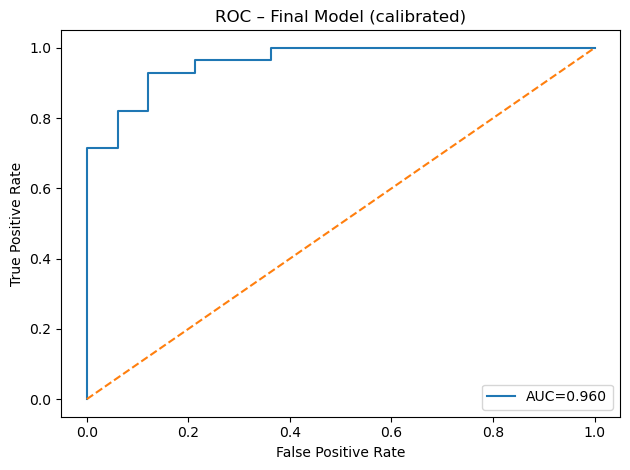

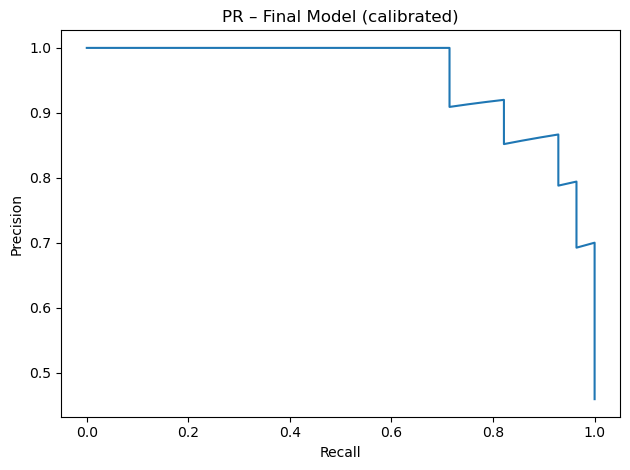

In [153]:
# ROC & PR sau calibration
plt.plot(fpr_cal, tpr_cal, label=f"AUC={roc_auc_score(y_test, y_score_cal):.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Final Model (calibrated)")
plt.legend()
plt.tight_layout()
plt.show()

prec_cal, rec_cal, _ = precision_recall_curve(y_test, y_score_cal)
plt.plot(rec_cal, prec_cal)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR – Final Model (calibrated)")
plt.tight_layout()
plt.show()

Brier score (calibrated, test): 0.0886


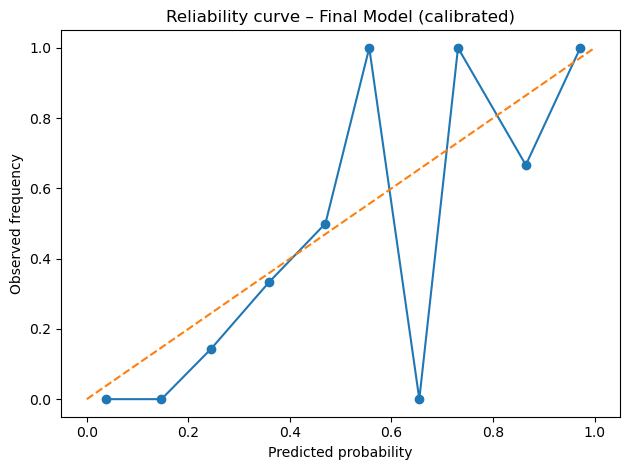

In [154]:
# Brier & reliability sau calibration
print("Brier score (calibrated, test):",
      round(brier_score_loss(y_test, y_score_cal), 4))

prob_true_c, prob_pred_c = calibration_curve(y_test, y_score_cal, n_bins=10)
plt.plot(prob_pred_c, prob_true_c, marker="o")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability curve – Final Model (calibrated)")
plt.tight_layout()
plt.show()

## Bootstrap CI cho AUC & F1


AUC 95% CI: [np.float64(0.91), np.float64(0.9934)]
F1  95% CI: [np.float64(0.7407), np.float64(0.9434)]


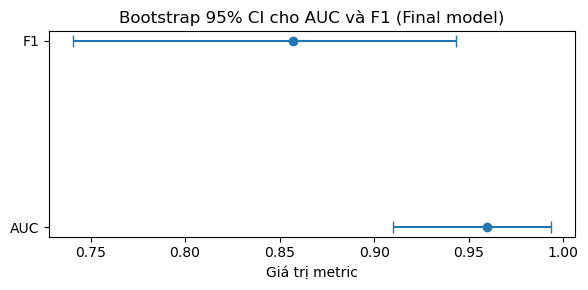

In [155]:
rng = np.random.default_rng(42)

def bootstrap_ci_metric(metric_fn, y_true, y_score_or_pred, kind="proba", B=2000):
    vals = []
    y_arr = y_true.values if hasattr(y_true, "values") else np.asarray(y_true)
    p_arr = np.asarray(y_score_or_pred)
    n = len(y_arr)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        if kind == "proba":
            vals.append(metric_fn(y_arr[idx], p_arr[idx]))
        else:
            vals.append(metric_fn(y_arr[idx], p_arr[idx]))
    return np.percentile(vals, [2.5, 97.5])

auc_ci = bootstrap_ci_metric(
    roc_auc_score, y_test, y_score_cal, kind="proba", B=2000
)
f1_ci = bootstrap_ci_metric(
    f1_score, y_test, y_pred_cal, kind="label", B=2000
)

print("\nAUC 95% CI:", [round(x, 4) for x in auc_ci])
print("F1  95% CI:", [round(x, 4) for x in f1_ci])

import numpy as np

metrics_ci = pd.DataFrame({
    "Metric":   ["AUC", "F1"],
    "Estimate": [
        roc_auc_score(y_test, y_score_cal),
        f1_score(y_test, y_pred_cal, zero_division=0)
    ],
    "CI_low":  [auc_ci[0], f1_ci[0]],
    "CI_high": [auc_ci[1], f1_ci[1]],
})

metrics_ci["err_low"]  = metrics_ci["Estimate"] - metrics_ci["CI_low"]
metrics_ci["err_high"] = metrics_ci["CI_high"] - metrics_ci["Estimate"]

plt.figure(figsize=(6, 3))
y_pos = np.arange(len(metrics_ci))

plt.errorbar(
    x=metrics_ci["Estimate"],
    y=y_pos,
    xerr=[metrics_ci["err_low"], metrics_ci["err_high"]],
    fmt="o",
    capsize=4,
)
plt.yticks(y_pos, metrics_ci["Metric"])
plt.xlabel("Giá trị metric")
plt.title("Bootstrap 95% CI cho AUC và F1 (Final model)")
plt.tight_layout()
plt.show()

### (1) Linear SHAP – áp dụng cho mô hình tuyến tính (vd Logistic Regression).  
### (2) Tree SHAP – áp dụng cho mô hình dạng cây (Decision Tree, RandomForest, XGBoost).  
### (3) Kernel SHAP – áp dụng cho các mô hình không có cấu trúc cây và không tuyến tính như SVM (RBF), Voting Ensemble.  
### (4) Gradient SHAP – áp dụng cho các mô hình sử dụng gradient như MLP Neural Network

In [156]:
import shap

# Lấy model cuối cùng (đã preprocess xong)
final_clf = final_model.named_steps["clf"]
preprocess_fitted = final_model.named_steps["pre"]

# Transform dữ liệu
X_test_trans = preprocess_fitted.transform(X_test)
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

model_name = type(final_clf).__name__

print("Best model:", model_name)

Best model: LogisticRegression


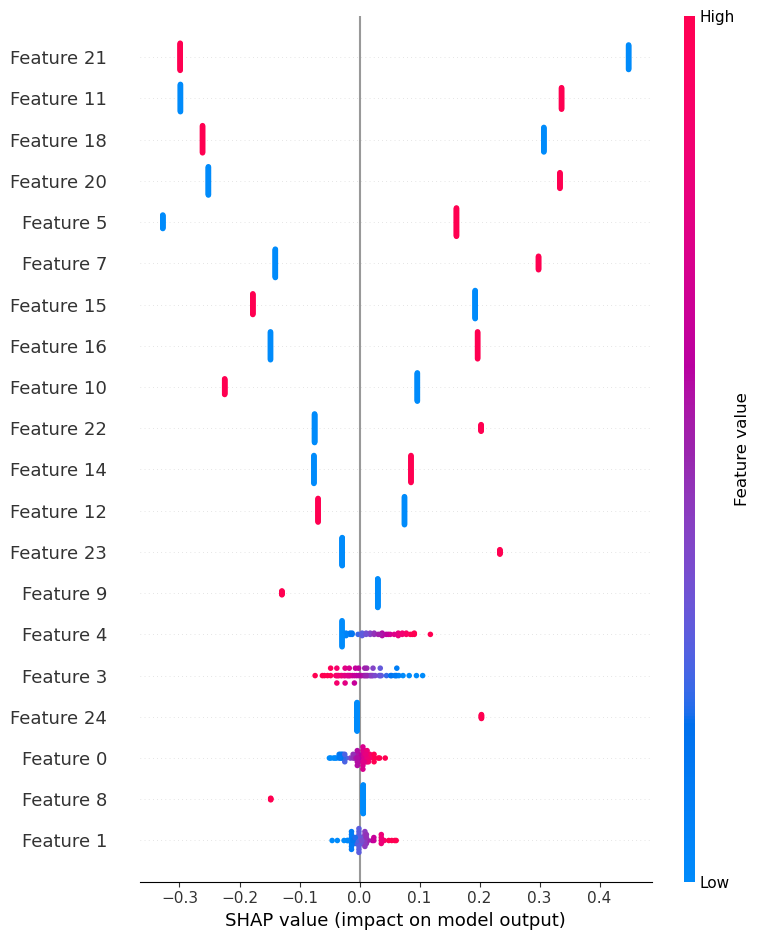

In [157]:
# ---- 1) Linear SHAP ----
if model_name in ["LogisticRegression", "LinearSVC"]:
    explainer = shap.LinearExplainer(final_clf, X_trainval_trans)
    shap_vals = explainer(X_test_trans)

# ---- 2) Tree SHAP ----
elif model_name in ["RandomForestClassifier", "DecisionTreeClassifier", "XGBClassifier"]:
    explainer = shap.TreeExplainer(final_clf)
    shap_vals = explainer(X_test_trans)

# ---- 3) Kernel SHAP ----
elif model_name in ["SVC", "VotingClassifier"]:
    # Lấy 100 sample để nhanh hơn
    X_sample = X_trainval_trans[:100]
    explainer = shap.KernelExplainer(final_clf.predict_proba, X_sample)
    shap_vals = explainer.shap_values(X_test_trans[:50])

# ---- 4) Gradient SHAP ----
elif model_name in ["MLPClassifier"]:
    explainer = shap.GradientExplainer(final_clf, X_trainval_trans)
    shap_vals = explainer.shap_values(X_test_trans)

else:
    raise Exception("Model không nằm trong 4 nhóm SHAP chính")

# ---- Plot SHAP ----
shap.summary_plot(shap_vals, X_test_trans)

In [158]:
import joblib

os.makedirs("models", exist_ok=True)

# Pipeline suy luận = preprocess (đã fit) + model đã calibrate
inference_model = Pipeline([
    ("pre", pre_fitted),
    ("clf", cal)
])
joblib.dump(inference_model, "models/best_model_calibrated.pkl")

clf_name = base.__class__.__name__

meta = {
    "model_name": f"{clf_name}_calibrated_isotonic_cv5",
    "model_version": "v1.0",
    "threshold": float(opt_th),        # ngưỡng chọn từ VALIDATION
    "feature_order": list(X.columns)       # thứ tự cột input raw Cleveland
}
with open("models/meta.json","w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("\nĐã lưu models/best_model_calibrated.pkl và models/meta.json")

if HAS_XGB:
    import xgboost
    print("XGBoost version:", xgboost.__version__)


Đã lưu models/best_model_calibrated.pkl và models/meta.json
XGBoost version: 3.1.1


In [159]:
def risk_tier(p):
    if p < 0.33:
        return "thấp"
    if p < 0.66:
        return "trung_binh"
    return "cao"

def personalize_recommendations(x, p=None, shap_top=None):
    """
    x: dict đầu vào gồm các keys của Cleveland (age, sex, cp, trestbps, chol, fbs, restecg,
                                              thalach, exang, oldpeak, slope, ca, thal)
    p: xác suất dự đoán của mô hình (0..1), nếu có
    shap_top: list[str] tên 3 đặc trưng có SHAP cao nhất (nếu bạn tính SHAP)
    """
    recs = []

    #  Lipid & đường huyết
    if x.get("chol") is not None:
        if x["chol"] >= 240:
            recs.append("Cholesterol cao: giảm chất béo bão hoà/chiên xào; tăng cá, hạt, rau ≥400g/ngày.")
        elif x["chol"] >= 200:
            recs.append("Cholesterol cận cao: duy trì chế độ DASH/Mediterranean và theo dõi định kỳ.")
    if x.get("fbs") == 1:
        recs.append("Đường huyết đói cao: ăn ít đường tinh luyện, tăng chất xơ; vận động 150 phút/tuần.")

    #  Huyết áp & gắng sức
    if x.get("trestbps") is not None:
        if x["trestbps"] >= 140:
            recs.append("Huyết áp cao: giảm muối <5g/ngày, đi bộ nhanh 30 phút/ngày, kiểm soát stress.")
        elif x["trestbps"] >= 130:
            recs.append("Huyết áp tăng nhẹ: duy trì vận động đều, hạn chế rượu bia, theo dõi HA.")
    if x.get("thalach") is not None and x["thalach"] < 120:
        recs.append("Thể lực thấp (thalach <120): bắt đầu luyện tập nhẹ–vừa 20–30 phút, 5 ngày/tuần.")
    if x.get("exang") == 1:
        recs.append("Đau ngực khi gắng sức: chỉ tập mức nhẹ–vừa; dừng nếu xuất hiện đau/khó thở/chóng mặt.")

    #  ST segment & ECG
    if x.get("oldpeak") is not None:
        if x["oldpeak"] > 2.0:
            recs.append("Oldpeak >2: giảm căng thẳng, ngủ 7–8h; nên tham khảo bác sĩ để đánh giá thêm.")
        elif x["oldpeak"] > 1.0:
            recs.append("Oldpeak 1–2: điều độ cường độ tập luyện, theo dõi triệu chứng khi vận động.")
    if x.get("slope") == 2:
        recs.append("Slope downsloping: thận trọng khi gắng sức; ưu tiên bài tập nhịp nhàng, quản lý stress.")
    if x.get("restecg") not in (None, 0):
        recs.append("Điện tâm đồ có bất thường: theo dõi triệu chứng, tránh tăng cường độ tập đột ngột.")

    #  Mạch vành & thal
    if x.get("ca") is not None and x["ca"] >= 1:
        recs.append("Có dấu hiệu tổn thương mạch (ca≥1): siết chặt lối sống, theo dõi HA/lipid; thận trọng gắng sức.")
    if x.get("thal") in (6,7):
        recs.append("Thal bất thường (6/7): ưu tiên bài tập nhẹ–vừa, chú ý dinh dưỡng; theo dõi mệt mỏi/khó thở.")

    #  Nhân khẩu & triệu chứng
    if x.get("age") is not None and x["age"] >= 55:
        recs.append("Tuổi ≥55: duy trì '3 tốt' (ăn lành mạnh, vận động đều, ngủ đủ); khám định kỳ 6–12 tháng.")
    if x.get("sex") == 1 and x.get("age", 0) >= 45:
        recs.append("Nam ≥45 tuổi: kiểm soát vòng eo, rượu bia; theo dõi lipid/huyết áp.")
    if x.get("cp") in (0,1):
        recs.append("Có triệu chứng đau ngực: theo dõi khi gắng sức; nếu đau lan tay/hàm hoặc khó thở → đi khám.")

    #  Tăng/giảm mức độ theo xác suất dự đoán
    if p is not None:
        tier = risk_tier(p)
        if tier == "cao":
            recs.insert(0, "Bạn thuộc nhóm NGUY CƠ CAO: nên tham khảo bác sĩ sớm.")
        elif tier == "trung_binh":
            recs.insert(0, "Nguy cơ TRUNG BÌNH: áp dụng khuyến nghị và tái kiểm tra sau 1–3 tháng.")
        else:
            recs.insert(0, "Nguy cơ THẤP hiện tại: duy trì lối sống lành mạnh và theo dõi định kỳ.")

    #  Nhấn mạnh theo SHAP (nếu có)
    if shap_top:
        recs.append(f"Yếu tố ảnh hưởng nhiều (SHAP): {', '.join(shap_top[:3])}. Tập trung cải thiện các yếu tố này.")

    # loại bỏ trùng lặp, giữ thứ tự
    seen, unique_recs = set(), []
    for r in recs:
        if r not in seen:
            unique_recs.append(r); seen.add(r)
    return unique_recs


In [160]:
# ví dụ thông tin 1 người
sample = {
    "age": 58, "sex": 1, "cp": 1, "trestbps": 148, "chol": 252, "fbs": 1,
    "restecg": 1, "thalach": 112, "exang": 1, "oldpeak": 2.3, "slope": 2, "ca": 1, "thal": 7
}

# p: xác suất từ pipeline dự đoán
# p = best_pipe.predict_proba(pd.DataFrame([sample]))[:,1][0]
p = 0.74  # minh hoạ

# shap_top: nếu bạn dùng SHAP, lấy top 3 feature tên thô (vd: ["chol","trestbps","oldpeak"])
shap_top = ["chol","oldpeak","trestbps"]

recs = personalize_recommendations(sample, p=p, shap_top=shap_top)
for i, r in enumerate(recs, 1):
    print(f"{i}. {r}")

1. Bạn thuộc nhóm NGUY CƠ CAO: nên tham khảo bác sĩ sớm.
2. Cholesterol cao: giảm chất béo bão hoà/chiên xào; tăng cá, hạt, rau ≥400g/ngày.
3. Đường huyết đói cao: ăn ít đường tinh luyện, tăng chất xơ; vận động 150 phút/tuần.
4. Huyết áp cao: giảm muối <5g/ngày, đi bộ nhanh 30 phút/ngày, kiểm soát stress.
5. Thể lực thấp (thalach <120): bắt đầu luyện tập nhẹ–vừa 20–30 phút, 5 ngày/tuần.
6. Đau ngực khi gắng sức: chỉ tập mức nhẹ–vừa; dừng nếu xuất hiện đau/khó thở/chóng mặt.
7. Oldpeak >2: giảm căng thẳng, ngủ 7–8h; nên tham khảo bác sĩ để đánh giá thêm.
8. Slope downsloping: thận trọng khi gắng sức; ưu tiên bài tập nhịp nhàng, quản lý stress.
9. Điện tâm đồ có bất thường: theo dõi triệu chứng, tránh tăng cường độ tập đột ngột.
10. Có dấu hiệu tổn thương mạch (ca≥1): siết chặt lối sống, theo dõi HA/lipid; thận trọng gắng sức.
11. Thal bất thường (6/7): ưu tiên bài tập nhẹ–vừa, chú ý dinh dưỡng; theo dõi mệt mỏi/khó thở.
12. Tuổi ≥55: duy trì '3 tốt' (ăn lành mạnh, vận động đều, ngủ đủ);